# ***Lecture des datasets (Code de Elissa)***

In [ ]:
import xml.etree.ElementTree as ET
import numpy as np

def load_xml_and_extract_matrix(xml_file_path):
    # Charger le fichier XML
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Trouver l'élément 'graph' qui contient les données de la matrice
    graph_element = root.find('graph')

    # Extraire la matrice symétrique
    return extract_symmetric_matrix(graph_element)

def extract_symmetric_matrix(graph_element):
    num_vertices = len(graph_element)  # Nombre de vertices (supposé carré)
    matrix = np.zeros((num_vertices, num_vertices), dtype=float)  # Initialiser la matrice de zéros

    # Parcourir chaque vertex
    for i, vertex in enumerate(graph_element):
        # Parcourir chaque edge du vertex
        for edge in vertex:
            j = int(edge.text) - 1  # Index du vertex connecté (base 1 à base 0)
            if i != j:  # Éviter de remplir la diagonale
                cost = float(edge.attrib['cost'])  # Coût de l'edge
                matrix[i, j] = cost
                matrix[j, i] = cost  # Assurer la symétrie

    return matrix

# Utiliser la fonction
file_path = '/content/gr21.xml'  # Remplacer par le chemin réel du fichier
distance_matrix = load_xml_and_extract_matrix(file_path)

# ***MMAS Expliquée et commentée***

***Initialisation :***
Les paramètres de l'algorithme sont  définis, y compris le nombre de villes, le nombre de fourmis, les paramètres d'importance de la phéromone et de l'heuristique, le taux d'évaporation de la phéromone, etc. De plus, une matrice de phéromone est initialisée avec des valeurs de départ égales à 1.

***Construction des solutions :***
Pour chaque itération, chaque fourmi construit une solution en visitant toutes les villes une seule fois. La ville de départ est choisie aléatoirement, puis chaque ville suivante est sélectionnée en fonction des probabilités calculées à partir des niveaux de phéromone et de l'heuristique.

***Évaluation des solutions :***
Une fois qu'une solution est construite, son coût est calculé en faisant la somme des distances entre les villes consécutives.

***Mise à jour des phéromones :***
Une fois que toutes les fourmis ont construit leurs solutions, les niveaux de phéromone sur chaque arête sont mis à jour en fonction de la qualité des solutions trouvées. Les arêtes fréquemment empruntées par les bonnes solutions reçoivent plus de phéromone.

***Mise à jour de la meilleure solution :***
À chaque itération, la meilleure solution trouvée est mise à jour si une solution meilleure est trouvée.

***Critère d'arrêt :***
L'algorithme continue à itérer selon un nombre maximal d'itérations prédéfini.

***Retour de la meilleure solution :***
Une fois que toutes les itérations sont terminées, l'algorithme retourne la meilleure solution trouvée et son coût.

***Max-Min :*** Cette caractéristique se réfère à la façon dont les niveaux de phéromone sont mis à jour. Les niveaux de phéromone sur les arêtes sont mis à jour de manière à ce qu'ils restent dans une plage spécifique, limitée entre une valeur minimale (Min) et une valeur maximale (Max). Cela évite que les niveaux de phéromone ne deviennent trop faibles ou trop élevés, ce qui pourrait compromettre la convergence de l'algorithme. Il permet à l'algorithme d'explorer différentes solutions tout en favorisant les chemins les plus courts en augmentant les niveaux de phéromone sur les arêtes empruntées par de bonnes solutions.

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Définition de la classe MMAS
class MMAS:
    def __init__(self, num_nodes, num_ants, max_iter, alpha, beta, rho, q, tau_min, tau_max):
        # Initialisation des paramètres de l'algorithme
        self.num_nodes = num_nodes  # Nombre de villes
        self.num_ants = num_ants  # Nombre de fourmis
        self.max_iter = max_iter  # Nombre maximal d'itérations
        self.alpha = alpha  # Importance de la phéromone
        self.beta = beta  # Importance de l'heuristique
        self.rho = rho  # Taux d'évaporation de la phéromone
        self.q = q  # Quantité de phéromone déposée
        self.tau_min = tau_min  # Limite inférieure de la phéromone
        self.tau_max = tau_max  # Limite supérieure de la phéromone

        # Initialisation de la meilleure solution et de son coût
        self.best_solution = None
        self.best_cost = float('inf')

        # Initialisation de la matrice de phéromones
        self.pheromone = np.ones((self.num_nodes, self.num_nodes))
        np.fill_diagonal(self.pheromone, 0)

    # Méthode principale pour exécuter l'algorithme
    def run(self, graph):
        # Boucle sur le nombre maximal d'itérations
        for _ in range(self.max_iter):
            # Construction des solutions par chaque fourmi
            solutions = self.construct_solutions(graph)
            # Mise à jour des phéromones
            self.update_pheromone(solutions)
            # Mise à jour de la meilleure solution
            self.update_best_solution(solutions)

        # Retourne la meilleure solution trouvée et son coût
        return self.best_solution, self.best_cost

    # Méthode pour construire les solutions de chaque fourmi
    def construct_solutions(self, graph):
        solutions = []
        for _ in range(self.num_ants):
            solution = self.construct_solution(graph)
            solutions.append((solution, self.evaluate_solution(graph, solution)))
        return solutions

    # Méthode pour construire la solution d'une fourmi
    def construct_solution(self, graph):
        solution = [np.random.randint(0, self.num_nodes)]
        visited = set(solution)

        while len(solution) < self.num_nodes:
            current = solution[-1]
            probabilities = self.compute_probabilities(graph, current, visited)
            next_node = np.random.choice(self.num_nodes, p=probabilities)
            solution.append(next_node)
            visited.add(next_node)

        return solution

    # Méthode pour calculer les probabilités de transition entre les villes
    def compute_probabilities(self, graph, current, visited):
        probabilities = np.zeros(self.num_nodes)
        pheromone = np.copy(self.pheromone[current])
        pheromone[list(visited)] = 0
        heuristic = 1 / (graph[current] + np.spacing(1))
        probabilities = (pheromone ** self.alpha) * (heuristic ** self.beta)
        probabilities /= np.sum(probabilities)
        return probabilities

    # Méthode pour évaluer le coût d'une solution
    def evaluate_solution(self, graph, solution):
        cost = 0
        for i in range(self.num_nodes):
            cost += graph[solution[i]][solution[(i + 1) % self.num_nodes]]
        return cost

    # Méthode pour mettre à jour les phéromones
    def update_pheromone(self, solutions):
        for i in range(self.num_nodes):
            for j in range(self.num_nodes):
                if i != j:
                    delta_tau = 0
                    for sol, cost in solutions:
                        if (i, j) in zip(sol, sol[1:] + [sol[0]]):
                            delta_tau += self.q / cost
                    self.pheromone[i][j] = (1 - self.rho) * self.pheromone[i][j] + delta_tau

        # Limiter les valeurs de phéromone entre tau_min et tau_max
        self.pheromone = np.clip(self.pheromone, self.tau_min, self.tau_max)

    # Méthode pour mettre à jour la meilleure solution
    def update_best_solution(self, solutions):
        for sol, cost in solutions:
            if cost < self.best_cost:
                self.best_solution = sol
                self.best_cost = cost

# Fonction pour créer un graphe complet avec des distances aléatoires entre les villes
def create_complete_graph(num_nodes):
    graph = np.random.rand(num_nodes, num_nodes)
    graph = (graph + graph.T) / 2  # rendre la matrice symétrique
    np.fill_diagonal(graph, 0)
    return graph

# Point d'entrée du programme
if __name__ == "__main__":
    num_nodes = 96  # Le nombre de villes dans votre matrice de distances
    num_ants = 10
    max_iter = 2000
    alpha = 1
    beta = 2
    rho = 0.1
    q = 100
    tau_min = 0.01
    tau_max = 10

    # Création d'une instance de l'algorithme MMAS
    mmas = MMAS(num_nodes, num_ants, max_iter, alpha, beta, rho, q, tau_min, tau_max)
    # Exécution de l'algorithme avec une matrice de distances
    best_solution, best_cost = mmas.run(create_complete_graph(num_nodes))

    # Affichage de la meilleure solution et de son coût
    print("Best solution:", best_solution)
    print("Best cost:", best_cost)


# ***Résultats***




```
Instances,Solution
17 Villes,2085
21 Villes,2798
24 Villes,1258
48 Villes,5094
96 Villes,93329
120 Villes,8866
```



1. **Initialisation :**
   - Nous définissons les paramètres de l'algorithme, tels que le nombre de villes (10), le nombre de fourmis (3), les paramètres d'importance de la phéromone et de l'heuristique, le taux d'évaporation de la phéromone, etc.
   - Une matrice de phéromone est initialisée avec des valeurs de départ égales à 1 pour chaque arête du graphe.

2. **Construction des solutions :**
   - Chaque itération, chaque fourmi commence sa tournée depuis une ville de départ choisie aléatoirement.
   - À chaque étape, la fourmi choisit la ville suivante à visiter en utilisant des probabilités calculées à partir des niveaux de phéromone sur les arêtes et de l'heuristique (par exemple, la distance entre les villes).
   - Les fourmis complètent leur tournée en visitant chaque ville exactement une fois.

3. **Évaluation des solutions :**
   - Une fois que chaque fourmi a construit sa solution (tournée), le coût de chaque solution est évalué en calculant la somme des distances entre les villes consécutives dans la tournée.

4. **Mise à jour des phéromones :**
   - Une fois que toutes les fourmis ont terminé leurs tournées, les niveaux de phéromone sur chaque arête sont mis à jour en fonction de la qualité des solutions trouvées.
   - Les arêtes fréquemment empruntées par les bonnes solutions reçoivent plus de phéromone, tandis que les arêtes moins fréquentes voient leur phéromone évaporer.

5. **Mise à jour de la meilleure solution :**
   - À chaque itération, la meilleure solution trouvée est mise à jour si une solution meilleure est trouvée.

6. **Critère d'arrêt :**
   - L'algorithme continue à itérer selon un nombre maximal d'itérations prédéfini.

7. **Retour de la meilleure solution :**
   - Une fois que toutes les itérations sont terminées, l'algorithme retourne la meilleure solution trouvée et son coût.

8. **Max-Min :**
   - Les niveaux de phéromone sur les arêtes sont mis à jour de manière à ce qu'ils restent dans une plage spécifique, limitée entre une valeur minimale (Min) et une valeur maximale (Max).
   - Cela garantit que les niveaux de phéromone ne deviennent pas trop faibles ou trop élevés, ce qui pourrait compromettre la convergence de l'algorithme.
   - L'algorithme explore ainsi différentes solutions tout en favorisant les chemins les plus courts en augmentant les niveaux de phéromone sur les arêtes empruntées par de bonnes solutions.

# ***Code à améliorer***

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

class MMAS:
    def __init__(self, num_nodes, num_ants, max_iter, alpha, beta, rho, q, tau_min, tau_max):
        self.num_nodes = num_nodes
        self.num_ants = num_ants
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q
        self.tau_min = tau_min
        self.tau_max = tau_max

        self.best_solution = None
        self.best_cost = float('inf')

        self.pheromone = np.ones((self.num_nodes, self.num_nodes))
        np.fill_diagonal(self.pheromone, 0)

    def run(self, graph):
        for _ in range(self.max_iter):
            solutions = self.construct_solutions(graph)
            self.update_pheromone(solutions)
            self.update_best_solution(solutions)

        return self.best_solution, self.best_cost

    def construct_solutions(self, graph):
        solutions = []
        for _ in range(self.num_ants):
            solution = self.construct_solution(graph)
            solutions.append((solution, self.evaluate_solution(graph, solution)))
        return solutions

    def construct_solution(self, graph):
        solution = [np.random.randint(0, self.num_nodes)]
        visited = set(solution)

        while len(solution) < self.num_nodes:
            current = solution[-1]
            probabilities = self.compute_probabilities(graph, current, visited)
            next_node = np.random.choice(self.num_nodes, p=probabilities)
            solution.append(next_node)
            visited.add(next_node)

        return solution

    def compute_probabilities(self, graph, current, visited):
        probabilities = np.zeros(self.num_nodes)
        pheromone = np.copy(self.pheromone[current])
        pheromone[list(visited)] = 0
        heuristic = 1 / (graph[current] + np.spacing(1))
        probabilities = (pheromone ** self.alpha) * (heuristic ** self.beta)
        probabilities /= np.sum(probabilities)
        return probabilities

    def evaluate_solution(self, graph, solution):
        cost = 0
        for i in range(self.num_nodes):
            cost += graph[solution[i]][solution[(i + 1) % self.num_nodes]]
        return cost

    def update_pheromone(self, solutions):
        for i in range(self.num_nodes):
            for j in range(self.num_nodes):
                if i != j:
                    delta_tau = 0
                    for sol, cost in solutions:
                        if (i, j) in zip(sol, sol[1:] + [sol[0]]):
                            delta_tau += self.q / cost
                    self.pheromone[i][j] = (1 - self.rho) * self.pheromone[i][j] + delta_tau

        self.pheromone = np.clip(self.pheromone, self.tau_min, self.tau_max)

    def update_best_solution(self, solutions):
        for sol, cost in solutions:
            if cost < self.best_cost:
                self.best_solution = sol
                self.best_cost = cost

def create_complete_graph(num_nodes):
    graph = np.random.rand(num_nodes, num_nodes)
    graph = (graph + graph.T) / 2  # make the matrix symmetric
    np.fill_diagonal(graph, 0)
    return graph

if __name__ == "__main__":
    num_nodes = 21  # Le nombre de villes dans votre matrice de distances
    num_ants = 10
    max_iter = 100
    alpha = 1
    beta = 2
    rho = 0.1
    q = 100
    tau_min = 0.01
    tau_max = 10

    """distance_matrix = [
        [0, 633.0, 257.0, 91.0, 412.0, 150.0, 80.0, 134.0, 259.0, 505.0, 353.0, 324.0, 70.0, 211.0, 268.0, 246.0, 121.0],
        [633.0, 0, 390.0, 661.0, 227.0, 488.0, 572.0, 530.0, 555.0, 289.0, 282.0, 638.0, 567.0, 466.0, 420.0, 745.0, 518.0],
        [257.0, 390.0, 0, 228.0, 169.0, 112.0, 196.0, 154.0, 372.0, 262.0, 110.0, 437.0, 191.0, 74.0, 53.0, 472.0, 142.0],
        [91.0, 661.0, 228.0, 0, 383.0, 120.0, 77.0, 105.0, 175.0, 476.0, 324.0, 240.0, 27.0, 182.0, 239.0, 237.0, 84.0],
        [412.0, 227.0, 169.0, 383.0, 0, 267.0, 351.0, 309.0, 338.0, 196.0, 61.0, 421.0, 346.0, 243.0, 199.0, 528.0, 297.0],
        [150.0, 488.0, 112.0, 120.0, 267.0, 0, 63.0, 34.0, 264.0, 360.0, 208.0, 329.0, 83.0, 105.0, 123.0, 364.0, 35.0],
        [80.0, 572.0, 196.0, 77.0, 351.0, 63.0, 0, 29.0, 232.0, 444.0, 292.0, 297.0, 47.0, 150.0, 207.0, 332.0, 29.0],
        [134.0, 530.0, 154.0, 105.0, 309.0, 34.0, 29.0, 0, 249.0, 402.0, 250.0, 314.0, 68.0, 108.0, 165.0, 349.0, 36.0],
        [259.0, 555.0, 372.0, 175.0, 338.0, 264.0, 232.0, 249.0, 0, 495.0, 352.0, 95.0, 189.0, 326.0, 383.0, 202.0, 236.0],
        [505.0, 289.0, 262.0, 476.0, 196.0, 360.0, 444.0, 402.0, 495.0, 0, 154.0, 578.0, 439.0, 336.0, 240.0, 685.0, 390.0],
        [353.0, 282.0, 110.0, 324.0, 61.0, 208.0, 292.0, 250.0, 352.0, 154.0, 0, 435.0, 287.0, 184.0, 140.0, 542.0, 238.0],
        [324.0, 638.0, 437.0, 240.0, 421.0, 329.0, 297.0, 314.0, 95.0, 578.0, 435.0, 0, 254.0, 391.0, 448.0, 157.0, 301.0],
        [70.0, 567.0, 191.0, 27.0, 346.0, 83.0, 47.0, 68.0, 189.0, 439.0, 287.0, 254.0, 0, 145.0, 202.0, 289.0, 55.0],
        [211.0, 466.0, 74.0, 182.0, 243.0, 105.0, 150.0, 108.0, 326.0, 336.0, 184.0, 391.0, 145.0, 0, 57.0, 426.0, 96.0],
        [268.0, 420.0, 53.0, 239.0, 199.0, 123.0, 207.0, 165.0, 383.0, 240.0, 140.0, 448.0, 202.0, 57.0, 0, 483.0, 153.0],
        [246.0, 745.0, 472.0, 237.0, 528.0, 364.0, 332.0, 349.0, 202.0, 685.0, 542.0, 157.0, 289.0, 426.0, 483.0, 0, 336.0],
        [121.0, 518.0, 142.0, 84.0, 297.0, 35.0, 29.0, 36.0, 236.0, 390.0, 238.0, 301.0, 55.0, 96.0, 153.0, 336.0, 0]
    ]"""

    mmas = MMAS(num_nodes, num_ants, max_iter, alpha, beta, rho, q, tau_min, tau_max)
    best_solution, best_cost = mmas.run(distance_matrix)

    print("Best solution:", best_solution)
    print("Best cost:", best_cost)



Best solution: [5, 7, 4, 3, 15, 10, 19, 9, 18, 20, 13, 0, 14, 12, 17, 16, 8, 1, 2, 11, 6]
Best cost: 2943.0


[[  0. 187. 196. 228. 112. 196. 167. 154. 209.  86. 223. 191. 180.  83.
   50. 219.  74. 139.  53.  43. 128.  99. 228. 142.]
 [187.   0. 228. 158.  96.  88.  59.  63. 286. 124.  49. 121. 315. 172.
  232.  92.  81.  98. 138. 200.  76.  89. 235.  99.]
 [196. 228.   0.  96. 120.  77. 101. 105. 159. 156. 185.  27. 188. 149.
  264.  82. 182. 261. 239. 232. 146. 221. 108.  84.]
 [228. 158.  96.   0.  77.  63.  56.  34. 190.  40. 123.  83. 193.  79.
  148. 119. 105. 144. 123.  98.  32. 105. 119.  35.]
 [112.  96. 120.  77.   0.  56.  25.  29. 216. 124. 115.  47. 245. 139.
  232.  31. 150. 176. 207. 200.  76. 189. 165.  29.]
 [196.  88.  77.  63.  56.   0.  29.  22. 229.  95.  86.  64. 258. 134.
  203.  43. 121. 164. 178. 171.  47. 160. 178.  42.]
 [167.  59. 101.  56.  25.  29.   0. 229. 225.  82.  90.  68. 228. 112.
  190.  58. 108. 136. 165. 131.  30. 147. 154.  36.]
 [154.  63. 105.  34.  29.  22. 229.   0.  82. 207. 313. 173.  29. 126.
  248. 238. 310. 389. 367. 166. 222. 349.  71. 220.]


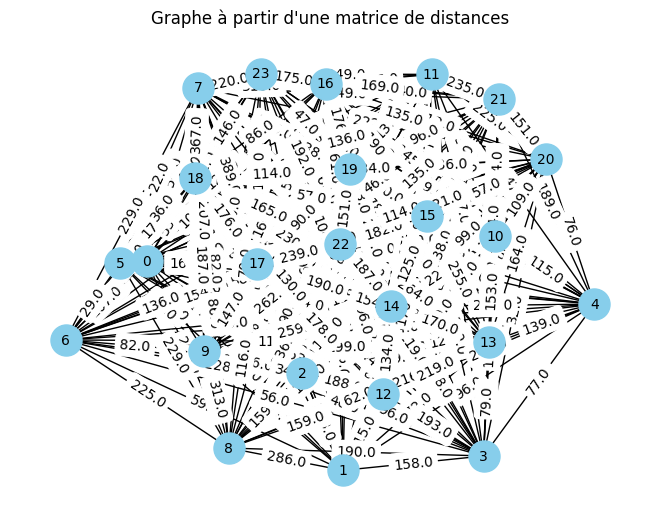

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Fonction pour créer un graphe à partir d'une matrice de distances
def matrix_to_graph(distance_matrix):
    num_nodes = len(distance_matrix)
    graph = nx.Graph()
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):  # Nous ne parcourons que la moitié supérieure de la matrice pour éviter les doublons
            graph.add_edge(i, j, weight=distance_matrix[i][j])  # Ajout d'une arête pondérée avec la distance
    return graph

print(distance_matrix)

# Transformation de la matrice en graphe
graph = matrix_to_graph(distance_matrix)

# Visualisation du graphe
pos = nx.spring_layout(graph)  # positionnement des nœuds
nx.draw(graph, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10)
labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
plt.title('Graphe à partir d\'une matrice de distances')
plt.show()


In [ ]:
import numpy as np

class MMAS:
    def __init__(self, num_nodes, num_ants, max_iter, alpha, beta, rho, q, tau_min, tau_max):
        self.num_nodes = num_nodes
        self.num_ants = num_ants
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q
        self.tau_min = tau_min
        self.tau_max = tau_max

        self.best_solution = None
        self.best_cost = float('inf')

        # Initialisation uniforme des phéromones
        initial_pheromone = 1 / (num_nodes * np.mean(graph))  # Exemple d'initialisation basée sur le graphe
        self.pheromone = np.full((num_nodes, num_nodes), initial_pheromone)
        np.fill_diagonal(self.pheromone, 0)

    def run(self, graph):
        for iteration in range(self.max_iter):
            solutions = self.construct_solutions(graph)
            self.update_pheromone(solutions)
            self.update_best_solution(solutions)
        return self.best_solution, self.best_cost

    def construct_solutions(self, graph):
        solutions = []
        for _ in range(self.num_ants):
            solution = self.construct_solution(graph)
            cost = self.evaluate_solution(graph, solution)
            solutions.append((solution, cost))
        return solutions

    def construct_solution(self, graph):
        solution = [np.random.randint(0, self.num_nodes)]
        visited = set(solution)
        while len(solution) < self.num_nodes:
            current = solution[-1]
            probabilities = self.compute_probabilities(graph, current, visited)
            next_node = np.random.choice(self.num_nodes, p=probabilities)
            solution.append(next_node)
            visited.add(next_node)
        solution.append(solution[0])  # Retour à la ville de départ pour former un cycle
        return solution

    def compute_probabilities(self, graph, current, visited):
        pheromone = self.pheromone[current]
        heuristic = 1 / (np.where(graph[current] > 0, graph[current], 1e10))  # Éviter la division par zéro
        attractiveness = (pheromone ** self.alpha) * (heuristic ** self.beta)
        mask = np.ones(self.num_nodes, dtype=bool)
        mask[list(visited)] = False
        probabilities = np.zeros(self.num_nodes)
        probabilities[mask] = attractiveness[mask]
        total = np.sum(probabilities)
        if total > 0:
            probabilities /= total
        else:
            probabilities[mask] = 1 / np.sum(mask)  # Éviter la division par zéro en distribuant uniformément
        return probabilities

    def evaluate_solution(self, graph, solution):
        cost = sum(graph[solution[i], solution[i+1]] for i in range(len(solution) - 1))
        return cost

    def update_pheromone(self, solutions):
        self.pheromone *= (1 - self.rho)  # Évaporation des phéromones
        for sol, cost in solutions:
            for i in range(len(sol) - 1):
                i, j = sol[i], sol[i+1]
                self.pheromone[i][j] += self.q / cost  # Dépôt des phéromones
        # Respecter les limites des phéromones
        self.pheromone = np.clip(self.pheromone, self.tau_min, self.tau_max)

    def update_best_solution(self, solutions):
        for sol, cost in solutions:
            if cost < self.best_cost:
                self.best_solution = sol
                self.best_cost = cost

mmas = MMAS(num_nodes, num_ants, max_iter, alpha, beta, rho, q, tau_min, tau_max)
best_solution, best_cost = mmas.run(graph)
print("Best solution:", best_solution)
print("Best cost:", best_cost)

In [ ]:
import random

# Fonction pour calculer la longueur du chemin
def tour_length(tour, distances):
    total_distance = 0
    for i in range(len(tour) - 1):
        total_distance += distances[tour[i]][tour[i+1]]
    return total_distance

# Fonction pour initialiser les phéromones sur chaque chemin
def initialize_pheromones(num_cities,v_init):
    pheromones = [[v_init] * num_cities for _ in range(num_cities)]
    return pheromones

# Algorithme ACO
def ant_colony_optimization(distances, num_ants, num_iterations,pheromones, alpha, beta, Q, evaporation_rate, min_pheromone, max_pheromone):
    num_cities = len(distances)
    best_solution = None
    best_distance = float('inf')

    for _ in range(num_iterations):
        pheromones_local= initialize_pheromones(num_cities, 0.0)
        best_ant_tour = None
        best_ant_distance = float('inf')

        for ant in range(num_ants):
            current_city = random.randint(0, num_cities - 1)
            tour = [current_city]
            visited = {current_city}

            while len(visited) < num_cities:
                probabilities = []
                total_pheromone = sum(pheromones[current_city][neighbor] ** alpha * (1 / distances[current_city][neighbor]) ** beta for neighbor in range(num_cities) if neighbor not in visited)
                for neighbor in range(num_cities):
                    if neighbor not in visited:
                        pheromone = pheromones[current_city][neighbor]
                        probability = (pheromone ** alpha) * ((1 / distances[current_city][neighbor]) ** beta) / total_pheromone
                        probabilities.append((neighbor, probability))

                next_city = random.choices([neighbor for neighbor, _ in probabilities], [prob for _, prob in probabilities])[0]
                tour.append(next_city)
                visited.add(next_city)
                current_city = next_city

            tour.append(tour[0])
            tour_dist = tour_length(tour, distances)

            if tour_dist < best_distance:
                best_solution = tour
                best_distance = tour_dist

            if tour_dist < best_ant_distance :
                best_ant_distance = tour_dist
                best_ant_tour = tour


        for i in range(len(best_ant_tour) - 1):
            pheromones_local[best_ant_tour[i]][best_ant_tour[i+1]] += Q / best_ant_distance

        for i in range(num_cities):
            for j in range(num_cities):
                pheromones[i][j] = (1 - evaporation_rate) * pheromones[i][j] + pheromones_local[i][j]
                pheromones[i][j] = max(min_pheromone, min(max_pheromone, pheromones[i][j]))


    return best_solution, best_distance

# Exemple d'utilisation

num_cities = len(distances)

min_pheromone = 0.00000001
max_pheromone = 1.0
num_ants = 101
num_iterations = 20
pheromones = initialize_pheromones(num_cities, min_pheromone)
alpha = 1.0
beta = 2.0
Q = 1
evaporation_rate = 0.5


best_solution, best_distance = ant_colony_optimization(distances, num_ants, num_iterations, pheromones, alpha, beta, Q, evaporation_rate, min_pheromone, max_pheromone)
print("Meilleure solution trouvée:", best_solution)
print("Longueur du meilleur chemin:", best_distance)

# ***MMAS***

In [116]:
import math
import time
def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def read_tsp_file(file_path):
    coordinates = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
        node_coord_section_index = lines.index('NODE_COORD_SECTION\n')
        for line in lines[node_coord_section_index + 1:]:
            if line.strip() == 'EOF':
                break
            parts = line.strip().split()
            node_id = int(parts[0])
            x, y = map(float, parts[1:])
            coordinates[node_id] = (x, y)
    return coordinates


def create_distance_matrix(coordinates):
    num_cities = len(coordinates)
    distance_matrix = [[0] * num_cities for _ in range(num_cities)]

    for i in range(1, num_cities + 1):
        for j in range(1, num_cities + 1):
            distance_matrix[i - 1][j - 1] = calculate_distance(coordinates[i], coordinates[j])

    return distance_matrix

# Example usage
file_path = "gil262.tsp"
coordinates = read_tsp_file(file_path)
distances = create_distance_matrix(coordinates)

In [120]:
import numpy as np

class MMAS:
    def __init__(self, num_nodes, num_ants, max_iter, alpha, beta, rho, q, tau_min, tau_max):
        # Initialisation des paramètres de l'algorithme
        self.num_nodes = num_nodes  # Nombre de villes
        self.num_ants = num_ants  # Nombre de fourmis
        self.max_iter = max_iter  # Nombre maximal d'itérations
        self.alpha = alpha  # Importance de la phéromone
        self.beta = beta  # Importance de l'heuristique
        self.rho = rho  # Taux d'évaporation de la phéromone
        self.q = q  # Quantité de phéromone déposée
        self.tau_min = tau_min  # Limite inférieure de la phéromone
        self.tau_max = tau_max  # Limite supérieure de la phéromone

        # Initialisation de la meilleure solution et de son coût
        self.best_solution = None
        self.best_cost = float('inf')

        # Initialisation de la matrice de phéromones
        self.pheromone = np.full((self.num_nodes, self.num_nodes), self.tau_max)

    # Méthode principale pour exécuter l'algorithme
    def run(self, distances):
        # Boucle sur le nombre maximal d'itérations
        for _ in range(self.max_iter):
            # Construction des solutions par chaque fourmi
            solutions = self.construct_solutions(distances)
            # Mise à jour des phéromones
            self.update_pheromone(solutions)
            # Mise à jour de la meilleure solution
            self.update_best_solution(solutions)

        # Retourne la meilleure solution trouvée et son coût
        return self.best_solution, self.best_cost

    # Méthode pour construire les solutions de chaque fourmi
    def construct_solutions(self, distances):
        solutions = []
        for _ in range(self.num_ants):
            solution = self.construct_solution(distances)
            solutions.append((solution, self.evaluate_solution(distances, solution)))
        return solutions

    # Méthode pour construire la solution d'une fourmi
    def construct_solution(self, distances):
        num_cities = len(distances)
        solution = [np.random.randint(0, num_cities)]
        visited = set(solution)

        while len(solution) < num_cities:
            current = solution[-1]
            probabilities = self.compute_probabilities(distances, current, visited)
            next_node = np.random.choice(num_cities, p=probabilities)
            solution.append(next_node)
            visited.add(next_node)

        return solution

    # Méthode pour calculer les probabilités de transition entre les villes
    def compute_probabilities(self, distances, current, visited):
        probabilities = np.zeros(len(distances))
        pheromone = np.copy(self.pheromone[current])
        pheromone[list(visited)] = 0
        heuristic = 1 / (np.array(distances[current]) + np.spacing(1))
        probabilities = (pheromone ** self.alpha) * (heuristic ** self.beta)
        probabilities /= np.sum(probabilities)
        return probabilities

    # Méthode pour évaluer le coût d'une solution
    def evaluate_solution(self, distances, solution):
        cost = 0
        num_cities = len(distances)
        for i in range(num_cities):
            cost += distances[solution[i]][solution[(i + 1) % num_cities]]
        return cost

    # Méthode pour mettre à jour les phéromones
    def update_pheromone(self, solutions):
            # Trouver la meilleure solution parmi toutes les fourmis
            best_ant_solution, best_ant_cost = min(solutions, key=lambda x: x[1])

            # Vérifier si le coût de la meilleure solution est différent de zéro
            if best_ant_cost != 0:
                delta_tau = self.q / best_ant_cost
            else:
                # Si le coût est zéro, utiliser une valeur par défaut pour delta_tau
                delta_tau = self.q / 1e-6  # Choisissez une petite valeur non nulle

            # Mise à jour des phéromones
            for i in range(self.num_nodes):
                for j in range(self.num_nodes):
                    if i != j:
                        self.pheromone[i][j] = (1 - self.rho) * self.pheromone[i][j] + delta_tau

            # Limiter les valeurs de phéromone entre tau_min et tau_max
            self.pheromone = np.clip(self.pheromone, self.tau_min, self.tau_max)

    # Méthode pour mettre à jour la meilleure solution
    def update_best_solution(self, solutions):
            best_solution, best_cost = min(solutions, key=lambda x: x[1])
            if best_cost < self.best_cost:
                self.best_solution = best_solution
                self.best_cost = best_cost

    # Méthode pour obtenir les coordonnées d'une solution
    def get_solution_coordinates(self, coordinates, solution):
        return [coordinates[node] for node in solution]

    # Méthode pour obtenir le cycle complet d'une solution
    def get_solution_cycle(self, solution):
        cycle = solution[:]  # Copie de la solution pour ne pas modifier l'original
        cycle.append(cycle[0])  # Ajout du premier nœud à la fin pour fermer le cycle
        return cycle

# Paramètres
num_nodes = len(distances)
num_ants = 50
max_iter = 100
alpha = 2
beta = 5
rho = 0.6
q = 60
tau_min = 0.1
tau_max = 40

mmas = MMAS(num_nodes, num_ants, max_iter, alpha, beta, rho, q, tau_min, tau_max)
best_solution, best_cost = mmas.run(distances)

# Afficher la meilleure solution trouvée
print("Meilleure solution trouvée:", best_solution)
print("Best cost:", best_cost)

Meilleure solution trouvée: [206, 165, 95, 197, 72, 203, 53, 260, 26, 194, 25, 147, 169, 229, 182, 57, 149, 35, 219, 205, 82, 216, 172, 136, 17, 29, 256, 123, 48, 11, 4, 132, 261, 190, 18, 184, 71, 78, 60, 89, 210, 30, 204, 141, 98, 69, 107, 243, 208, 137, 20, 99, 144, 114, 3, 80, 185, 171, 139, 159, 163, 6, 245, 140, 73, 103, 125, 115, 214, 212, 111, 7, 189, 122, 117, 2, 134, 83, 145, 42, 222, 121, 224, 240, 10, 234, 81, 156, 61, 248, 176, 68, 236, 223, 162, 249, 63, 124, 1, 252, 113, 192, 100, 202, 56, 130, 213, 55, 241, 37, 38, 15, 5, 164, 36, 221, 84, 110, 235, 22, 195, 173, 142, 13, 106, 97, 239, 116, 91, 177, 209, 40, 109, 19, 108, 28, 226, 59, 157, 131, 96, 104, 180, 170, 168, 51, 74, 161, 58, 218, 14, 101, 232, 175, 135, 225, 31, 77, 258, 16, 39, 23, 244, 200, 50, 66, 133, 146, 158, 126, 174, 46, 54, 167, 102, 65, 112, 193, 79, 41, 196, 237, 9, 255, 152, 8, 88, 166, 12, 247, 120, 188, 105, 64, 227, 52, 129, 128, 220, 228, 0, 138, 201, 230, 67, 231, 154, 75, 153, 86, 33, 94, 257